In [1]:
import sys
import os

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

import pandas as pd

from NeuralNetwork import Neural_Network
from GD_class import GradientDescent
from cost_functions import grad_mse
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm import tqdm 

import seaborn as sns



# Importing the data and splitting into test and training set

In [2]:
data = pd.read_pickle('Data.pickle')
data

,Irradiance,Air_temperature,Water_temperature,Wind_speed,Wind_direction,Relative_humidity,Module_temperature
TIMESTAMP,,,,,,,
2022-09-21 00:00:00,0.000000,10.64959,18.23309,0.718167,122.80310,90.83396,8.767621
2022-09-21 00:01:00,0.000000,10.66724,18.22307,0.468167,157.02360,90.82109,8.735371
2022-09-21 00:02:00,0.000000,10.80340,18.22233,0.490833,143.28760,91.84943,8.718043
2022-09-21 00:03:00,0.000000,10.80551,18.21201,0.562373,123.01450,91.87434,8.720935
2022-09-21 00:04:00,0.000000,10.84426,18.20765,0.517000,119.85300,91.75574,8.718635
...,...,...,...,...,...,...,...
2022-12-11 23:55:00,1.400486,22.33173,23.23995,2.932373,135.64730,79.05765,20.798378
2022-12-11 23:56:00,1.344832,22.34635,23.22682,2.972500,133.17300,79.55808,20.844978
2022-12-11 23:57:00,1.296964,22.35988,23.22584,2.706000,114.33010,79.75605,20.892388


In [3]:
X = jnp.array(data.iloc[:, :-1])
target = jnp.array(data.iloc[:, -1]).reshape(-1, 1)

In [4]:
test_size = 0.2
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)

In [5]:
# Setting up some common parameters for all runs:
n_outputs = 1
n_features = X.shape[1] 

In [6]:
# Scaling the X-values

# Using scikit-learns StandardScaler
x_scaler = StandardScaler()

# Fit the scaler on the training data
x_scaler.fit(X_train)

# Transform the training data
X_train_scaled = x_scaler.transform(X_train)

# Transform the test data
X_test_scaled = x_scaler.transform(X_test)

# Transform all the data
X_all_scaled = x_scaler.transform(X)

In [8]:
# Scaling the target values

y_scaler = StandardScaler()

# Fit the scaler on the training target
y_scaler.fit(target_train)

# Transform the training target
target_train_scaled = y_scaler.transform(target_train)

# Tuning the number of minibatches and epochs

In [9]:
n_hidden_layers = 2
n_hidden_nodes = 10

activation_hidden = "sigmoid"

learning_rate = 0.01
lmbd = 0.0001

n_epochs_list = [50, 100, 150]
n_minibatches_list = [8, 16, 32]

mse = np.zeros((len(n_epochs_list), len(n_minibatches_list)))
r2 = np.zeros((len(n_epochs_list), len(n_minibatches_list)))

kfold = KFold(n_splits=5, shuffle=True)

for k, n_epochs in enumerate(n_epochs_list):

    for i, n_minibatches in tqdm(enumerate(n_minibatches_list)):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):
            
            # Splitting the data into training and validation set for cross-validation
            X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
            target_train_cv, target_val_cv = target_train_scaled[train_index], target_train_scaled[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[k][i] = np.mean(mse_crossval)
        r2[k][i] = np.mean(r2_crossval)


3it [12:34, 251.57s/it]
3it [04:06, 82.09s/it] 
3it [02:53, 57.71s/it]


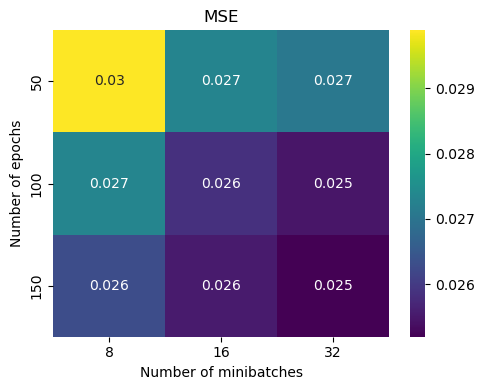

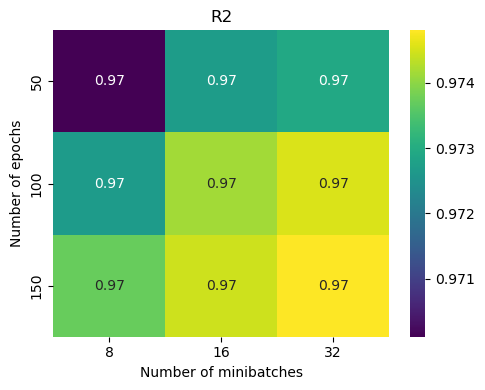

In [11]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_minibatches_list)
heatmap.set_yticklabels(n_epochs_list)
ax.set_title("MSE")
ax.set_ylabel("Number of epochs")
ax.set_xlabel("Number of minibatches")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_epochs_and_minibatches_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_minibatches_list)
heatmap.set_yticklabels(n_epochs_list)
ax.set_title("R2")
ax.set_ylabel("Number of epochs")
ax.set_xlabel("Number of minibatches")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_epochs_and_minibatches_R2.png")
plt.show()

In [12]:
# Best results:
n_epochs = 150
n_minibatches = 32

# Tuning number of hidden layers and hidden nodes

In [13]:
n_hidden_layers_list = [2, 3, 4]
n_hidden_nodes_list = [5, 10, 15, 20]

activation_hidden = "sigmoid"

learning_rate = 0.01
lmbd = 0.0001

mse = np.zeros((len(n_hidden_layers_list), len(n_hidden_nodes_list)))
r2 = np.zeros((len(n_hidden_layers_list), len(n_hidden_nodes_list)))

kfold = KFold(n_splits=5, shuffle=True)

for k, n_hidden_layer in tqdm(enumerate(n_hidden_layers_list)):

    for i, n_hidden_nodes in enumerate(n_hidden_nodes_list):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):
            
            # Splitting the data into training and validation set for cross-validation
            X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
            target_train_cv, target_val_cv = target_train_scaled[train_index], target_train_scaled[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches) 
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[k][i] = np.mean(mse_crossval)
        r2[k][i] = np.mean(r2_crossval)


3it [36:54, 738.25s/it] 


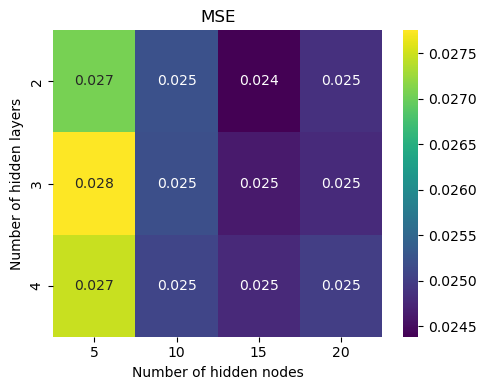

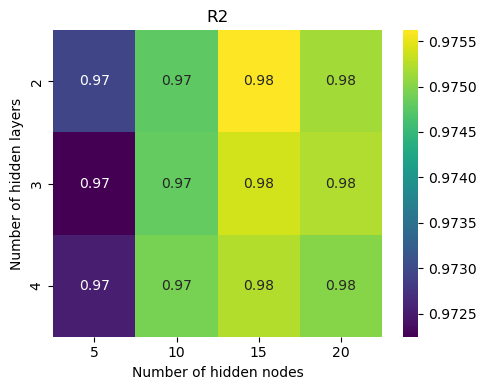

In [15]:
fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_hidden_nodes_list)
heatmap.set_yticklabels(n_hidden_layers_list)
ax.set_title("MSE")
ax.set_ylabel("Number of hidden layers")
ax.set_xlabel("Number of hidden nodes")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_hidden_layers_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (5, 4))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(n_hidden_nodes_list)
heatmap.set_yticklabels(n_hidden_layers_list)
ax.set_title("R2")
ax.set_ylabel("Number of hidden layers")
ax.set_xlabel("Number of hidden nodes")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_hidden_layers_R2.png")
plt.show()

In [16]:
# Best results:
n_hidden_layers = 2
n_hidden_nodes = 15

# Tuning lambda and learning rate

In [18]:
activation_hidden = "sigmoid"

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-4, 0, 5)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

kfold = KFold(n_splits=5, shuffle=True)

for i, learning_rate in tqdm(enumerate(learning_rates)):

    for j, lmbd in enumerate(lmbd_vals):

        mse_crossval = []
        r2_crossval = []

        for train_index, val_index in kfold.split(X_train):

            X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
            target_train_cv, target_val_cv = target_train_scaled[train_index], target_train_scaled[val_index]

            ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                  grad_cost_function=grad_mse,
                                  learning_rate=learning_rate, 
                                  lmbd=lmbd, 
                                  activation_function_hidden=activation_hidden,
                                  activation_function_output='Linear',
                                  optimizer=None,
                                  classification_problem=False)

            ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, 
                       n_minibatches=n_minibatches)
            pred_val = ffnn.predict(X_val_cv)

            mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
            r2_crossval.append(r2_score(target_val_cv, pred_val))

        mse[i][j] = np.mean(mse_crossval)
        r2[i][j] = np.mean(r2_crossval)


4it [59:59, 1006.40s/it]C:\Users\vildesn\FYS_STK_4155\Project_3\src\activation_functions.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\vildesn\FYS_STK_4155\Project_3\src\activation_functions.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\vildesn\FYS_STK_4155\Project_3\src\activation_functions.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\vildesn\FYS_STK_4155\Project_3\src\activation_functions.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
5it [1:08:47, 825.41s/it]


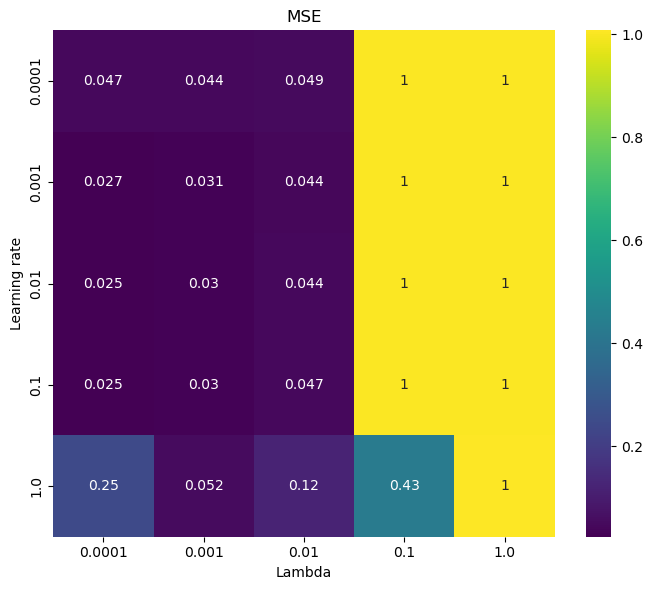

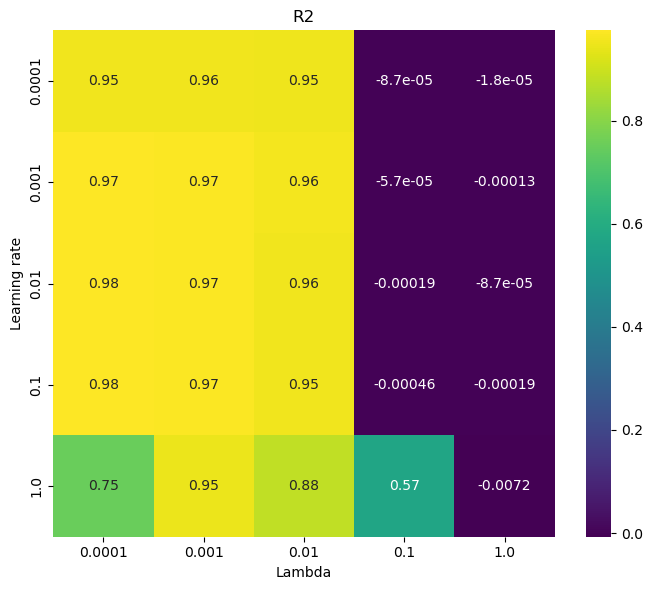

In [19]:
fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE")
ax.set_ylabel('Learning rate')
ax.set_xlabel('Lambda')
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_lambda_and_lr_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2")
ax.set_ylabel('Learning rate')
ax.set_xlabel('Lambda')
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Tune_lambda_and_lr_R2.png")
plt.show()

## Testing different activation functions

### Rectified Linear Unit (ReLU)

In [24]:
activation_hidden = "ReLU"

learning_rates = np.logspace(-4, 0, 5)
lmbd_vals = np.logspace(-4, 0, 5)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in tqdm(enumerate(learning_rates)):

        for j, lmbd in enumerate(lmbd_vals):

            mse_crossval = []
            r2_crossval = []

            for train_index, val_index in kfold.split(X_train):

                X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
                target_train_cv, target_val_cv = target_train_scaled[train_index], target_train_scaled[val_index]

                ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                      grad_cost_function=grad_mse,
                                      learning_rate=lr, 
                                      lmbd=lmbd, 
                                      activation_function_hidden=activation_hidden,
                                      activation_function_output='Linear',
                                      optimizer=None,
                                      classification_problem=False)

                ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
                pred_val = ffnn.predict(X_val_cv)

                mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
                r2_crossval.append(r2_score(target_val_cv, pred_val))

            mse[i][j] = np.mean(mse_crossval)
            r2[i][j] = np.mean(r2_crossval)

5it [1:24:09, 1009.97s/it]


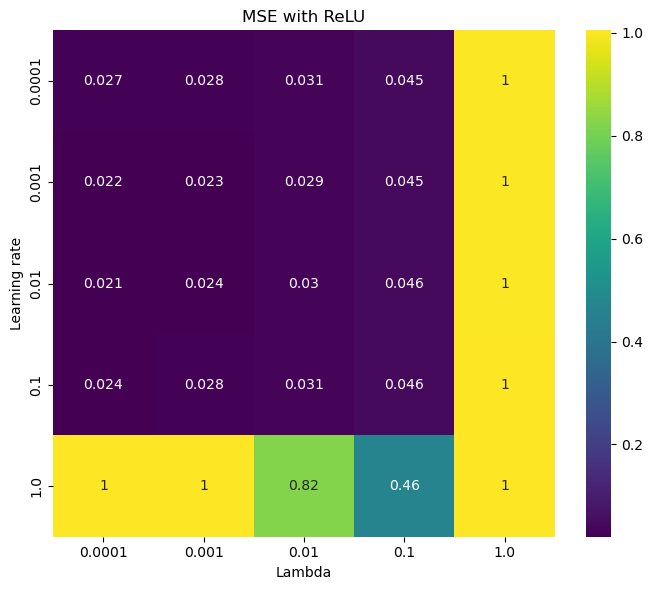

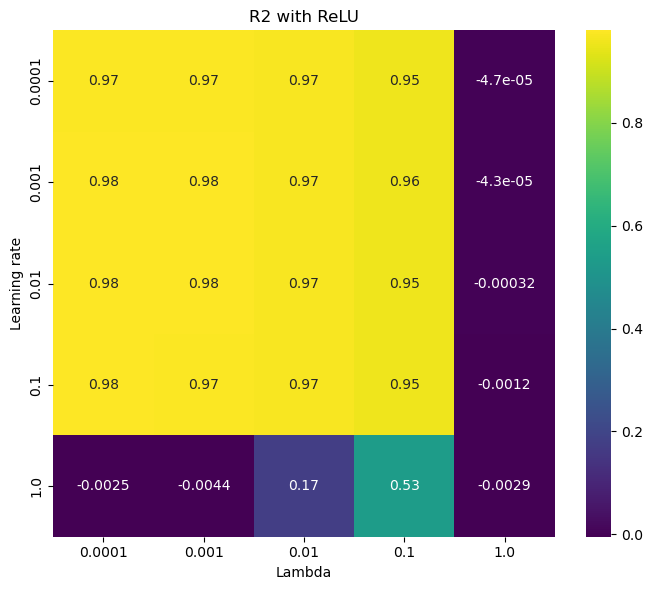

In [25]:
fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE with ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Testing_ReLU_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2 with ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Testing_ReLU_R2.png")
plt.show()

In [26]:
np.min(mse)

0.020874354988336563

In [27]:
np.max(r2)

0.9791277898758457

### Leaky ReLU

In [28]:
activation_hidden = 'Leaky ReLU'

learning_rates = np.logspace(-4, -1, 4)
lmbd_vals = np.logspace(-4, 0, 5)

mse = np.zeros((len(learning_rates), len(lmbd_vals)))
r2 = np.zeros((len(learning_rates), len(lmbd_vals)))

for i, lr in tqdm(enumerate(learning_rates)):

        for j, lmbd in enumerate(lmbd_vals):

            mse_crossval = []
            r2_crossval = []

            for train_index, val_index in kfold.split(X_train):

                X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
                target_train_cv, target_val_cv = target_train_scaled[train_index], target_train_scaled[val_index]

                ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                                      grad_cost_function=grad_mse,
                                      learning_rate=lr, 
                                      lmbd=lmbd, 
                                      activation_function_hidden=activation_hidden,
                                      activation_function_output='Linear',
                                      optimizer=None,
                                      classification_problem=False)

                ffnn.train(X_train_cv, target_train_cv, num_iter=n_epochs, n_minibatches=n_minibatches)
                pred_val = ffnn.predict(X_val_cv)

                mse_crossval.append(mean_squared_error(target_val_cv, pred_val))
                r2_crossval.append(r2_score(target_val_cv, pred_val))

            mse[i][j] = np.mean(mse_crossval)
            r2[i][j] = np.mean(r2_crossval)




4it [25:12, 378.02s/it]


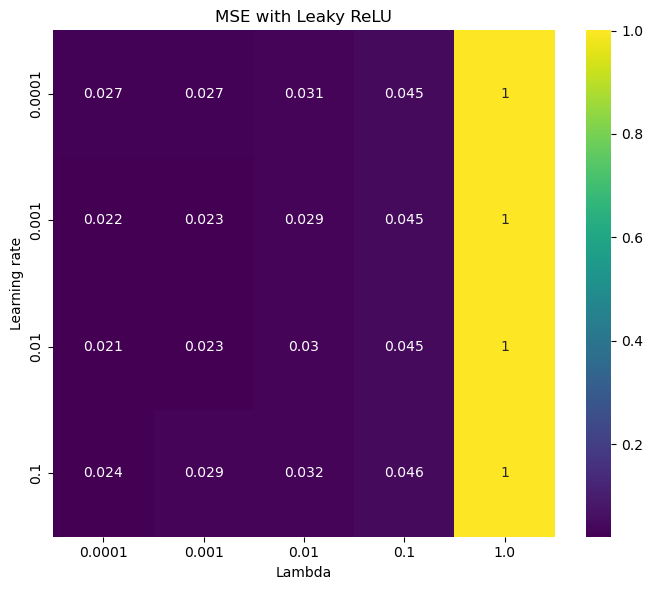

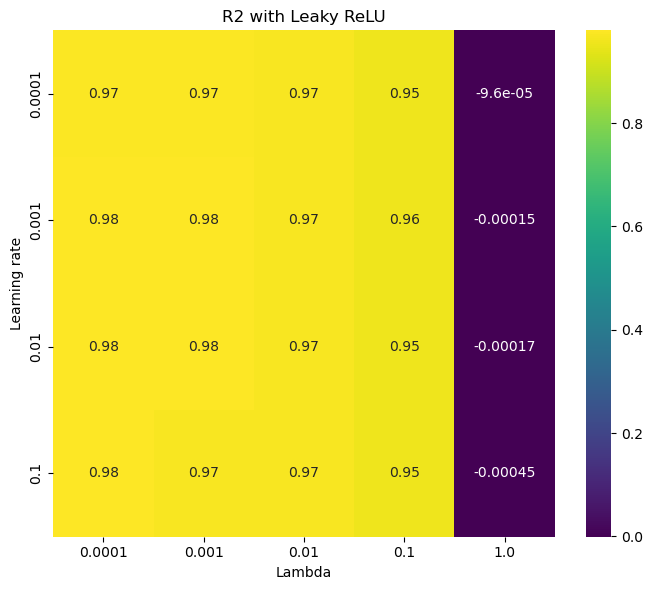

In [29]:
fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(mse, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("MSE with Leaky ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Testing_LeakyReLU_MSE.png")
plt.show()

fig, ax = plt.subplots(figsize = (7, 6))
heatmap = sns.heatmap(r2, annot=True, ax=ax, cmap="viridis")
heatmap.set_xticklabels(lmbd_vals)
heatmap.set_yticklabels(learning_rates)
ax.set_title("R2 with Leaky ReLU")
ax.set_ylabel("Learning rate")
ax.set_xlabel("Lambda")
plt.tight_layout()
plt.savefig(r"Figures\FFNN\Testing_LeakyReLU_R2.png")
plt.show()

In [32]:
np.min(mse)

0.020658006891608238

In [33]:
np.max(r2)

0.9793450256237681

## Final test of model

In [34]:
# Best results
activation_hidden = 'Leaky ReLU'

learning_rate = 0.01
lmbd = 0.0001 


In [35]:
# Training the network again with all the training data and the tuned parameters
ffnn = Neural_Network(n_features, n_hidden_layers, n_hidden_nodes, n_outputs, 
                      grad_cost_function=grad_mse,
                      learning_rate=learning_rate, lmbd=lmbd, 
                      activation_function_hidden=activation_hidden,
                      activation_function_output='Linear',
                      optimizer=None,
                      classification_problem=False)

ffnn.train(X_train_scaled, target_train_scaled, num_iter=n_epochs, n_minibatches=n_minibatches)
pred_test_scaled = ffnn.predict(X_test_scaled)
pred_test = y_scaler.inverse_transform(pred_test_scaled) 

mse_test = mean_squared_error(target_test, pred_test)
r2_test = r2_score(target_test, pred_test)

print(f"MSE for test data: {mse_test}")
print(f"R2 for test data: {r2_test}")

MSE for test data: 3.885934829711914
R2 for test data: 0.9793624706527694


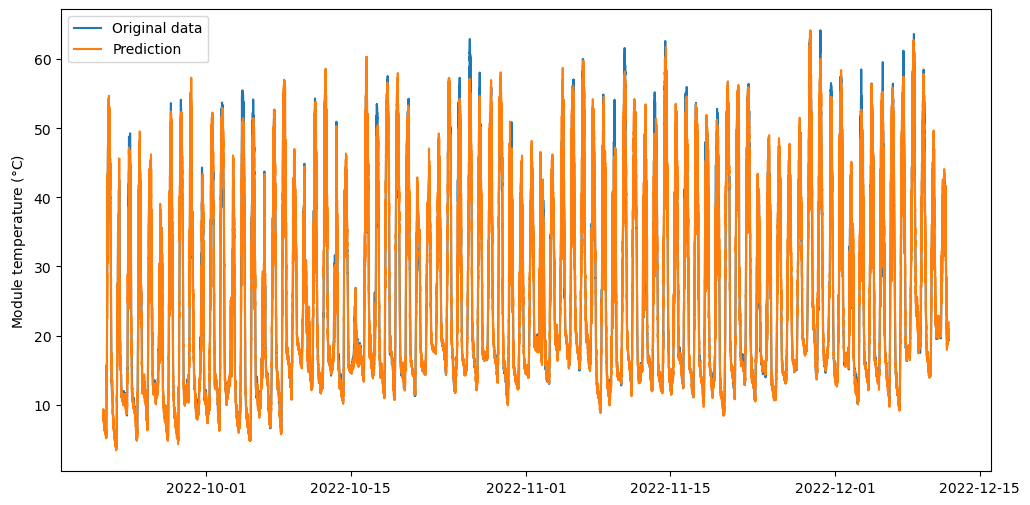

In [38]:
# Plotting the prediction together with the original data

y_pred_all_scaled = ffnn.predict(X_all_scaled)
y_pred_all = y_scaler.inverse_transform(y_pred_all_scaled) 

plt.figure(figsize=(12, 6))
plt.plot(data.index, target, label="Original data")
plt.plot(data.index, y_pred_all, label="Prediction")
plt.ylabel(r"Module temperature ($\degree$C)")
plt.legend()
plt.savefig(r"Figures\FFNN\Plot_of_predicted_and_original_data.png")
plt.show()

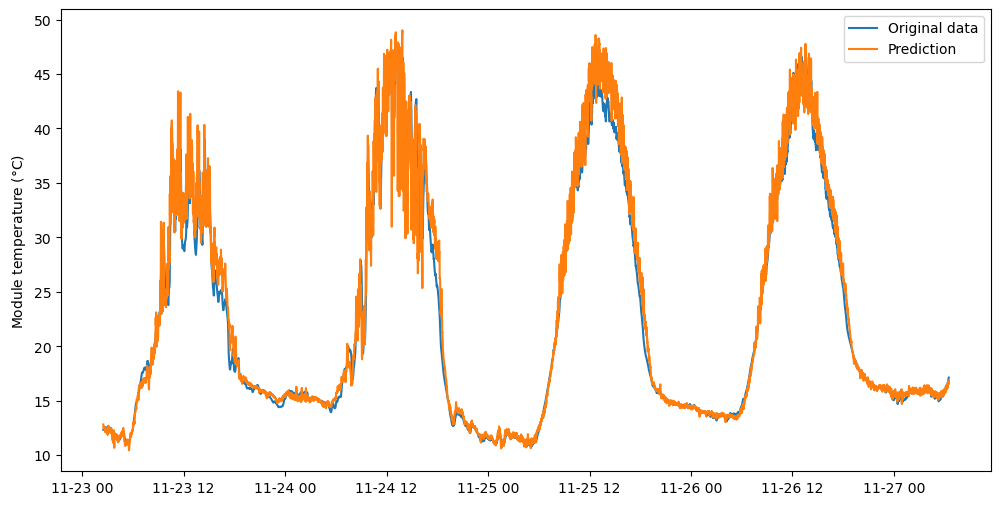

In [39]:
# Only looking at some days

plt.figure(figsize=(12, 6))
plt.plot(data.iloc[90000:96000, :].index, target[90000:96000, :], label="Original data")
plt.plot(data.iloc[90000:96000, :].index, y_pred_all[90000:96000, :], label="Prediction")
plt.ylabel(r"Module temperature ($\degree$C)")
plt.legend()
plt.savefig(r"Figures\FFNN\Plot_of_predicted_and_original_data_some_days.png")
plt.show()